Plot NWP, PV, GSP PV, and ESO PV forecasts

Based on: https://github.com/openclimatefix/predict_pv_yield_OLD/blob/main/notebooks/data_analysis/001-animate_sat_images_and_pv.ipynb

In [180]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from matplotlib import cm
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import dask
from IPython import display
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
START_TIME = "2021-06-10 04:00"
END_TIME = "2021-06-10 21:00"

In [3]:
BASE_PATH = Path("/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/")
SATELLITE_PATH = BASE_PATH / "satellite/EUMETSAT/SEVIRI_RSS/zarr/v3/eumetsat_seviri_hrv_uk.zarr"
NWP_PATH = BASE_PATH / "NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr"
PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/Passiv/ocf_formatted/v0")
GSP_PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/GSP/v3/pv_gsp.zarr")
GSP_SHAPE = Path("~/dev/ocf/nowcasting_dataset/nowcasting_dataset/data_sources/gsp/gsp_shape/").expanduser()
GSP_METADATA = Path("~/dev/ocf/nowcasting_dataset/nowcasting_dataset/data_sources/gsp/eso_metadata.csv").expanduser()
ESO_PV_FORECAST_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/other_organisations_pv_forecasts/National_Grid_ESO/NetCDF/ESO_GSP_PV_forecasts.nc")

WGS84 = "EPSG:4326"

assert SATELLITE_PATH.exists()
assert NWP_PATH.exists()
assert PV_PATH.exists()
assert GSP_PV_PATH.exists()
assert GSP_SHAPE.exists()
assert GSP_METADATA.exists()
assert ESO_PV_FORECAST_PATH.exists()

## Open and prepare satellite data

In [4]:
satellite_dataset = xr.open_dataset(SATELLITE_PATH, engine="zarr", chunks="auto")

In [5]:
satellite_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>

In [6]:
selected_sat_dataset = satellite_dataset.sel(time=slice(START_TIME, END_TIME))["data"]
sat_datetime_index = pd.DatetimeIndex(selected_sat_dataset.time)

In [7]:
# Compute min and max values (these will be used during plotting to make sure the "exposure" doesn't change from frame-to-frame).
min_satellite_value = selected_sat_dataset.min()
max_satellite_value = selected_sat_dataset.max()
min_satellite_value, max_satellite_value = dask.compute(min_satellite_value, max_satellite_value)

## Open and prepare NWP data

In [8]:
nwp_dataset = xr.open_dataset(NWP_PATH, engine="zarr", chunks="auto")

In [9]:
def get_nwp_data(dt: pd.Timestamp, variable: str = "dswrf") -> xr.DataArray:
    dt = pd.Timestamp(dt)
    dt_hourly = dt.floor("H")
    init_time_i = np.searchsorted(nwp_dataset.init_time, dt_hourly.to_numpy(), side="right")
    init_time_i -= 1  # Because searchsorted() gives the index to the entry _after_.
    init_time = nwp_dataset.init_time.values[init_time_i]
    step = dt_hourly - init_time
    return nwp_dataset["UKV"].sel(init_time=init_time, step=step, variable=variable)

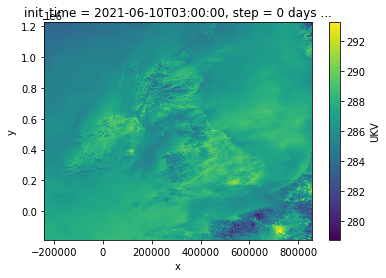

In [10]:
get_nwp_data(START_TIME, variable="t").plot();

In [11]:
nwp_min = nwp_dataset.sel(init_time=slice(START_TIME, END_TIME))["UKV"].min(dim=["x", "y", "init_time", "step"])
nwp_max = nwp_dataset.sel(init_time=slice(START_TIME, END_TIME))["UKV"].max(dim=["x", "y", "init_time", "step"])
nwp_min, nwp_max = dask.compute(nwp_min, nwp_max)

## Open and prepare GSP PV data from PV Live

In [149]:
gsp_pv_dataset = xr.open_dataset(GSP_PV_PATH, engine="zarr").sel(datetime_gmt=slice(START_TIME, END_TIME))

In [151]:
gsp_pv_df = gsp_pv_dataset["generation_mw"].to_pandas()

In [152]:
gsp_metadata = pd.read_csv(GSP_METADATA, usecols=["gsp_id", "gsp_name", "region_id"]).dropna().astype({"gsp_id": int, "region_id": int}).set_index("region_id")

In [153]:
gsp_shape = gpd.read_file(GSP_SHAPE)

In [154]:
gsp_shape = gsp_shape.join(gsp_metadata, on="RegionID").set_index("gsp_id")

In [155]:
gsp_shape

,RegionID,RegionName,cen_x,cen_y,cen_lat,cen_lon,geometry,gsp_name
gsp_id,,,,,,,,
20,149,Beddington (_J),536188.353965,153184.379039,51.261557,-0.049493,"POLYGON ((543750.561 167428.882, 549430.486 13...",BEDD_1
27,150,Northfleet East,562905.369691,156371.196102,51.283187,0.334557,"POLYGON ((571652.936 143992.711, 550968.129 13...",NFLE
294,155,Sellindge,603591.567662,135280.229043,51.080709,0.905299,"POLYGON ((624923.598 137169.470, 624894.947 13...",SELL_1
323,160,Richborough,631523.349693,156148.808737,51.257472,1.316827,"POLYGON ((626375.397 137910.687, 623652.026 16...",RICH1
295,156,Chessington,517564.146384,155903.402341,51.290137,-0.315393,"POLYGON ((523319.962 166572.557, 526121.634 14...",CHSI_1
...,...,...,...,...,...,...,...,...
106,60,Iron Acton,360399.106146,175513.972539,51.477188,-2.571607,"MULTIPOLYGON (((371321.522 169758.107, 369859....",IROA1
121,67,Landulph,236193.727900,66565.874760,50.475953,-4.309967,"MULTIPOLYGON (((238210.000 33959.000, 238174.0...",LAND1
334,18,Melksham,374787.393690,164683.411687,51.380632,-2.363658,"POLYGON ((374188.174 155409.620, 372306.229 16...",MELK_1


In [156]:
# Four GSP IDs have multiple shapes. Merge those shapes
duplicated_gsp_ids = gsp_shape.index[gsp_shape.index.duplicated()]
print(f"{duplicated_gsp_ids=}")
for duplicated_gsp_id in duplicated_gsp_ids:
    unary_union = gsp_shape.geometry.loc[duplicated_gsp_id].unary_union
    gsp_metadata = gsp_shape.loc[duplicated_gsp_id].iloc[0]
    gsp_shape.drop(duplicated_gsp_id, inplace=True)
    gsp_metadata['geometry'] = unary_union
    gsp_shape.loc[duplicated_gsp_id] = gsp_metadata
    
assert not gsp_shape.index.duplicated().any()

duplicated_gsp_ids=Int64Index([141, 118, 106, 334], dtype='int64', name='gsp_id')


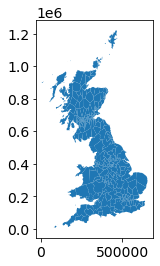

In [157]:
gsp_shape.plot();

In [158]:
gsp_shape = gsp_shape.loc[gsp_pv_df.columns]
gsp_shape

,RegionID,RegionName,cen_x,cen_y,cen_lat,cen_lon,geometry,gsp_name
gsp_id,,,,,,,,
1,1,Cowley,448889.644160,206989.365607,51.759469,-1.293039,"POLYGON ((487588.011 199546.288, 487595.132 19...",COWL_1
2,19,East Claydon,472005.739028,237635.701248,52.032476,-0.951777,"POLYGON ((496184.317 245725.992, 496123.631 24...",ECLA_1
3,20,Enderby,451521.981357,306026.426142,52.649551,-1.239877,"POLYGON ((444809.038 322857.985, 445184.574 32...",ENDE_1
4,21,Grendon,483798.618486,285794.816938,52.463693,-0.767987,"POLYGON ((474705.047 330704.521, 475706.249 32...",GREN_1
5,22,Ratcliffe,459869.284136,324199.443470,52.812046,-1.113203,"MULTIPOLYGON (((456985.595 342513.345, 457193....",RATS_1
...,...,...,...,...,...,...,...,...
334,18,Melksham,399910.183013,159440.767849,51.334056,-2.002669,"POLYGON ((431103.209 173178.693, 429491.981 16...",MELK_1
335,132,Knaresborough,435628.316462,469958.011013,54.124268,-1.456358,"POLYGON ((457669.188 490340.135, 459083.009 48...",KNAR
336,114,Wylfa,233135.276581,374042.059774,53.237133,-4.501757,"MULTIPOLYGON (((227890.259 342451.377, 219808....",WYLF_1


In [159]:
gsp_shape_by_gsp_name = gsp_shape.set_index("gsp_name")["geometry"]

In [160]:
gsp_shape_by_gsp_id = gsp_shape.geometry

In [161]:
del gsp_shape

In [162]:
assert np.all(gsp_pv_df.columns == gsp_shape_by_gsp_id.index)

## Open and prepare PV data

In [25]:
pv_dataset = xr.open_dataset(PV_PATH / "passiv.netcdf")

In [26]:
pv_dataset = pv_dataset.sel(datetime=slice(START_TIME, END_TIME))

In [27]:
pv_data_array = pv_dataset.to_array(dim="pv_system_id")

In [28]:
pv_df = pv_data_array.T.to_pandas()

In [29]:
del pv_dataset, pv_data_array

In [30]:
pv_df = pv_df.dropna(axis='columns', how='all')

In [31]:
pv_df.columns = pv_df.columns.astype(int)

In [32]:
pv_metadata = pd.read_csv(PV_PATH / "system_metadata.csv", index_col="system_id", usecols=["system_id", "latitude", "longitude"])

In [33]:
pv_metadata = pv_metadata.loc[pv_df.columns]

In [34]:
pv_df = pv_df / pv_df.max()

<AxesSubplot:xlabel='datetime'>

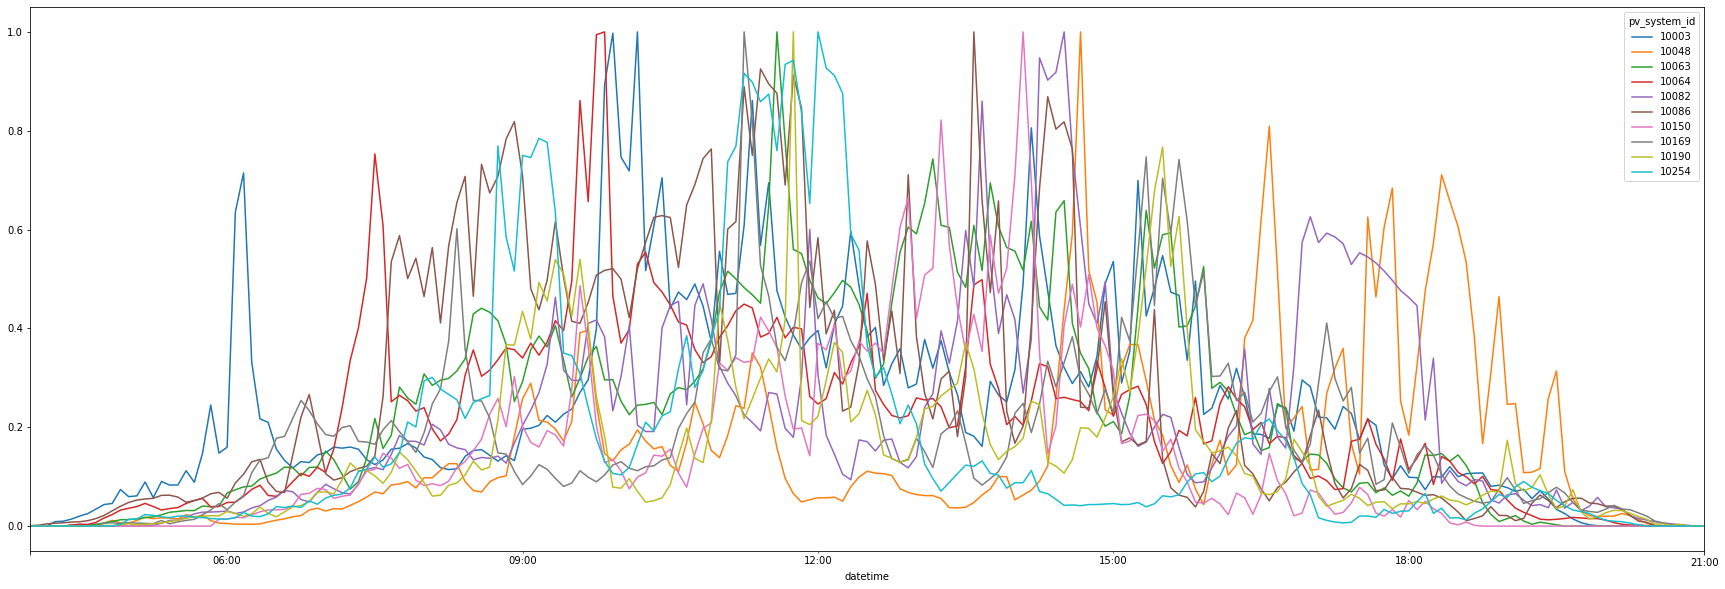

In [35]:
pv_df.iloc[:, 0:10].plot(figsize=(30, 10))

## ESO PV forecasts

In [36]:
eso_pv_forecasts = xr.open_dataset(ESO_PV_FORECAST_PATH, mode='r')

In [128]:
eso_pv_forecasts_selected = eso_pv_forecasts["ML"].sel(
    forecast_date_time=slice(
        pd.Timestamp(START_TIME) - pd.Timedelta("1H"), 
        END_TIME)
).isel(step=slice(1, 6))

In [129]:
eso_pv_forecasts_selected_df = eso_pv_forecasts_selected.stack(target_time=("forecast_date_time", "step")).T.to_pandas()

In [130]:
eso_pv_forecasts_selected_df = eso_pv_forecasts_selected_df.reset_index()

In [131]:
eso_pv_forecasts_selected_df["target_time"] = eso_pv_forecasts_selected_df["forecast_date_time"] + eso_pv_forecasts_selected_df["step"]

In [132]:
eso_pv_forecasts_selected_df = eso_pv_forecasts_selected_df.sort_values(["target_time", "forecast_date_time"]).drop_duplicates(subset="target_time", keep="first")

In [133]:
eso_pv_forecasts_selected_df = eso_pv_forecasts_selected_df.drop(columns=["forecast_date_time", "step"]).set_index("target_time")

In [135]:
# Prepare to normalise

In [136]:
gsp_pv_capacity_by_gsp_id = gsp_pv_dataset["installedcapacity_mwp"].sel(datetime_gmt=START_TIME).to_series()

In [137]:
gsp_pv_capacity_by_gsp_name = pd.concat((gsp_metadata.set_index("gsp_id")["gsp_name"], gsp_pv_capacity_by_gsp_id), axis=1).set_index("gsp_name").squeeze()

In [138]:
# Align gsp_shape_by_gsp_name and eso_pv_forecast_selected_df so the correct things are plotted later...

In [139]:
gsp_names = gsp_shape_by_gsp_name.index.intersection(eso_pv_forecasts_selected_df.columns)

In [140]:
gsp_names = np.sort(gsp_names)

In [141]:
gsp_shape_by_gsp_name = gsp_shape_by_gsp_name.loc[gsp_names]

In [142]:
eso_pv_forecasts_selected_df = eso_pv_forecasts_selected_df[gsp_names]

## Animate!

```

########### ########### ########### ########### 
#  nwp    # #   sat & # #   GSP   # #  ESO PV # 
#  dswrf  # #    PV   # #    PV   # # FCST ERR# 
########### ########### ########### ########### 

###############################################
#   price, freq, demand                       #
###############################################

```

In [42]:
def get_pv_colors_for_datetime(dt, df, cmap=cm.get_cmap('plasma')) -> np.ndarray:
    colors = df.loc[dt]
    colors = np.ma.masked_array(colors, mask=colors.isna())
    return cmap(colors)

In [175]:
def plot_gsp_power_heatmap(
    ax: plt.Axes, 
    dt: pd.Timestamp, 
    gsp_shape: pd.Series, 
    gsp_pv_power: pd.Series
) -> plt.Axes:
    
    dt = pd.Timestamp(dt)
    gsp_shape_with_values = gsp_shape.to_frame()
    gsp_shape_with_values["power"] = gsp_pv_power.loc[dt.ceil("30T")]
    gsp_shape_with_values.plot(
        column="power",
        ax=ax,
        transform=ccrs.OSGB(approx=False),
        cmap="plasma",
        vmin=0,
        vmax=1,
    )
    
    return ax


def plot_pv_live_heatmap(ax, dt) -> plt.Axes:
    plot_gsp_power_heatmap(ax=ax, dt=dt, gsp_shape=gsp_shape_by_gsp_id, gsp_pv_power=gsp_pv_df / gsp_pv_capacity_by_gsp_id)
    gsp_ax.set_title("GSP PV (from Sheffield Solar PV Live)")
    
    
def plot_eso_pv_forecast_heatmap(ax, dt) -> plt.Axes:
    plot_gsp_power_heatmap(ax=ax, dt=dt, gsp_shape=gsp_shape_by_gsp_name, gsp_pv_power=eso_pv_forecasts_selected_df / gsp_pv_capacity_by_gsp_name)
    eso_pv_ax.set_title("NG-ESO GSP PV forecast")

/tmp/ipykernel_17264/850936121.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(


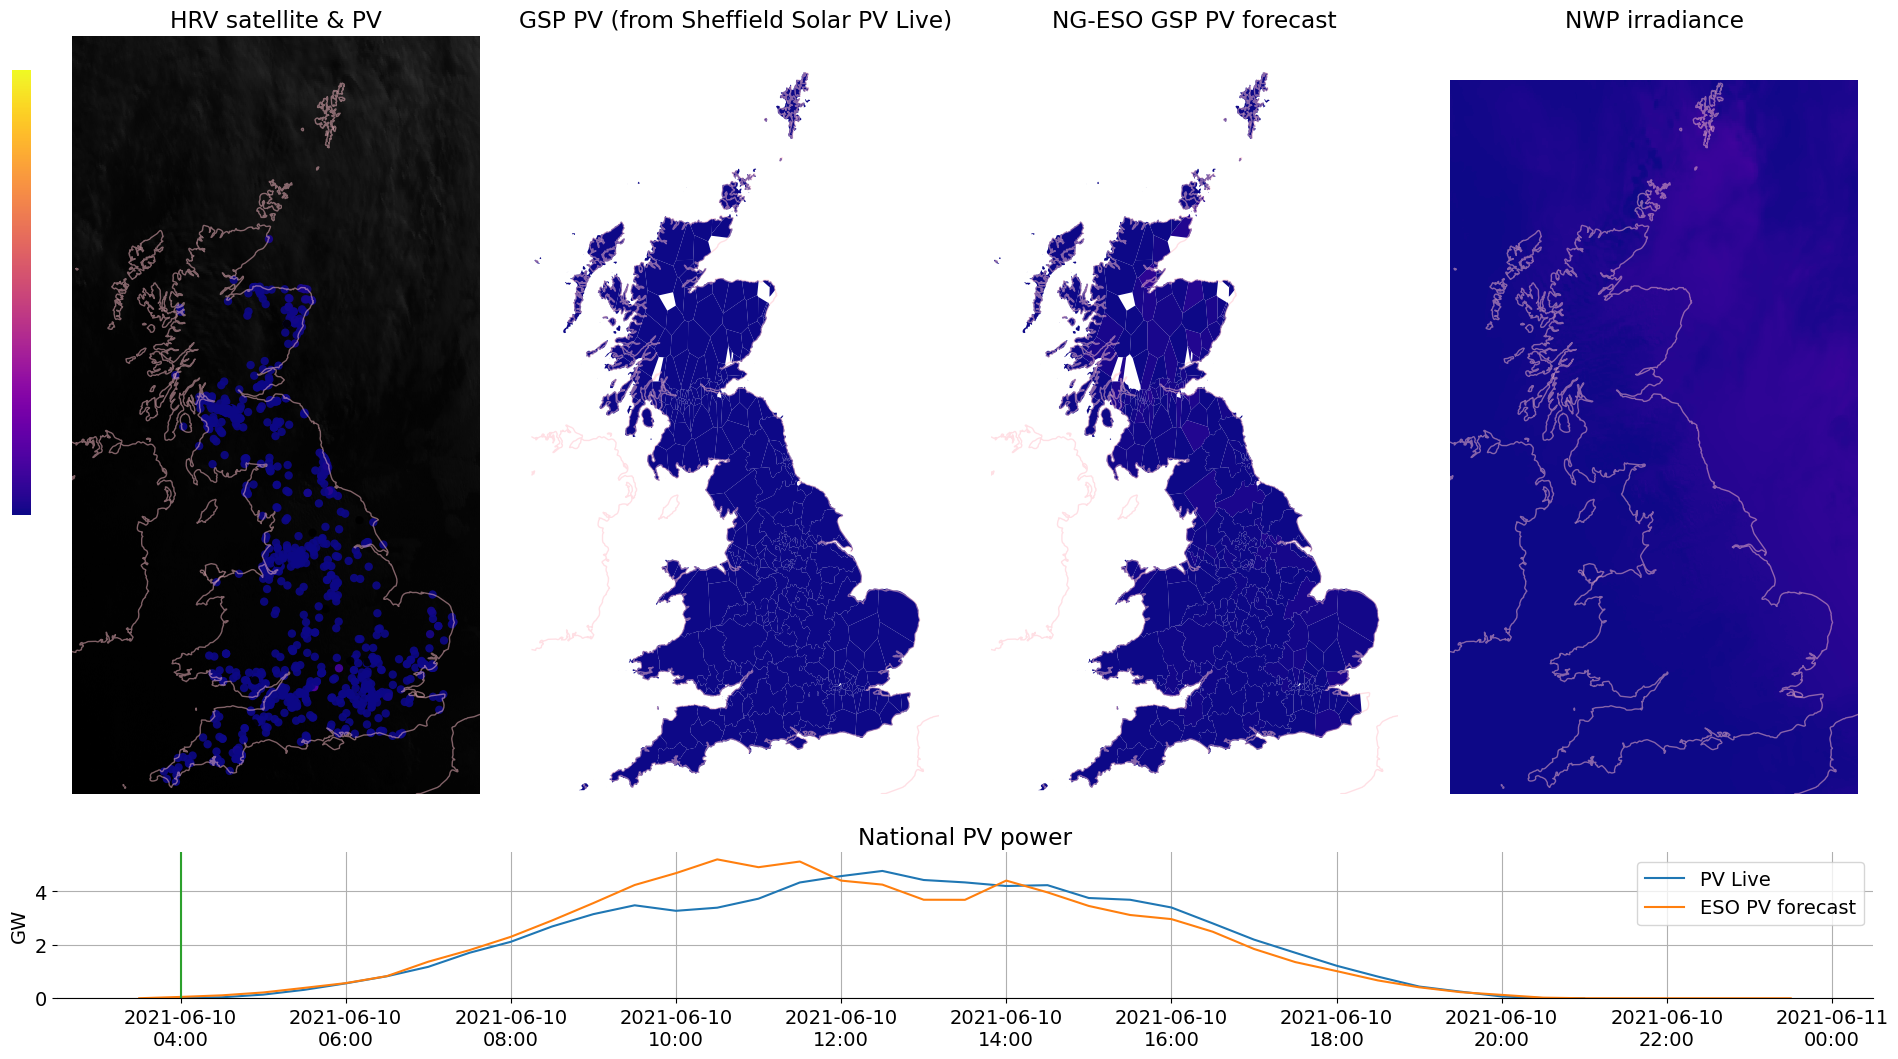

In [254]:
# SET UP THE FIGURE
# Spatial layout
NROWS = 5
NCOLS = 4
SHAPE = (NROWS, NCOLS)
dpi = 100
plt.rcParams['figure.dpi'] = dpi

fig = plt.figure(
    figsize=(
        # Very slightly increase the figure size because, for some reason, without these adjustments, matplotlib doesn't output a video which is exactly 1920x1080 pixels.
        19.20,# * (1920/1898), 
        10.80 * (1080 / 1052) * (1080 / 1078)  # tried: 1028.5->1081, 1028.55->1081, 1028.6->1079, 1028.75->1079
    ))
projection = ccrs.OSGB(approx=False)
geospatial_plot_kwargs = dict(projection=projection, rowspan=NROWS-1)
sat_and_pv_ax = plt.subplot2grid(shape=SHAPE, loc=(0, 0), **geospatial_plot_kwargs)
gsp_ax = plt.subplot2grid(SHAPE, loc=(0, 1), **geospatial_plot_kwargs)
eso_pv_ax = plt.subplot2grid(SHAPE, loc=(0, 2), **geospatial_plot_kwargs)
nwp_ax = plt.subplot2grid(SHAPE, loc=(0, 3), **geospatial_plot_kwargs)
timeseries_ax = plt.subplot2grid(SHAPE, loc=(NROWS-1, 0), colspan=NCOLS)
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.99, top=0.99, wspace=None, hspace=None)

# From https://stackoverflow.com/a/39566040/732596
FONT_SIZE = 14
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels

# Colours
#fig.patch.set_facecolor('black')
#sat_and_pv_ax.set_facecolor('black')

## SATELLITE ####################################################
# Plot first frame of satellite data
sat_img = selected_sat_dataset.isel(time=0).plot.pcolormesh(
    ax=sat_and_pv_ax,
    transform=ccrs.Geostationary(central_longitude=9.5),
    x="x",
    y="y",
    add_colorbar=False,
    cmap="gray",
    vmin=min_satellite_value.data,
    vmax=max_satellite_value.data,
)

## PV ###########################################################
pv_scatter = sat_and_pv_ax.scatter(
    x=pv_metadata.longitude,
    y=pv_metadata.latitude,
    alpha=0.9,
    linewidth=0,
    transform=ccrs.PlateCarree(),
)
pv_scatter.set_color(get_pv_colors_for_datetime(START_TIME, df=pv_df))
sat_and_pv_ax.set_title("HRV satellite & PV")

## NWP #########################################################
selected_nwp_data = get_nwp_data(START_TIME, variable="dswrf")
nwp_img = selected_nwp_data.plot.pcolormesh(
    ax=nwp_ax,
    transform=ccrs.OSGB(approx=False),
    add_colorbar=False,
    cmap="plasma",
    vmin=nwp_min.sel(variable="dswrf").values,
    vmax=nwp_max.sel(variable="dswrf").values,
)
nwp_ax.set_title("NWP irradiance")
nwp_ax.set_ylim(sat_and_pv_ax.get_ylim())
nwp_ax.set_xlim(sat_and_pv_ax.get_xlim())

## GSP PV power from PV Live #################################
plot_pv_live_heatmap(ax=gsp_ax, dt=START_TIME)

## GSP PV power from PV Live #################################
plot_eso_pv_forecast_heatmap(ax=eso_pv_ax, dt=START_TIME)

## Colour bar ##############################################
colorbar_ax = plt.axes([0.012, 0.5, 0.01, 0.4]) # left, bottom, width, height
plt.colorbar(nwp_img, ticks=[], cax=colorbar_ax)
colorbar_ax.set_frame_on(False)

## FORMAT GEO PLOTS #########################################
for ax in [nwp_ax, sat_and_pv_ax, gsp_ax, eso_pv_ax]:
    ax.coastlines(resolution='10m', alpha=0.5, color='pink')
    ax.set_frame_on(False)

## TIMESERIES PLOT ##########################################
timeseries_ax.plot(gsp_pv_df.sum(axis='columns') / 1000, label="PV Live")
timeseries_ax.plot(eso_pv_forecasts_selected_df.sum(axis='columns') / 1000, label="ESO PV forecast")

timeseries_ax.grid()
timeseries_ax.legend()
timeseries_ax.set_title("National PV power")
timeseries_ax.set_ylabel("GW")
timeseries_ax.set_ylim(0, timeseries_ax.get_ylim()[1])
timeseries_ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
for spine in ('top', 'right', 'left'):
    timeseries_ax.spines[spine].set_visible(False)

time_marker = timeseries_ax.plot(
    (sat_datetime_index[0], sat_datetime_index[0]),
    timeseries_ax.get_ylim(),
)[0]

plt.tight_layout(
    h_pad=3, 
    rect=(0, 0, 1, 0.95),  # left, bottom, right, top
)

In [255]:
# Animation function
def update(i: int = 0):
    # Satellite
    new_sat_data = selected_sat_dataset.isel(time=i)
    sat_img.set_array(new_sat_data.values.ravel())
    dt = pd.Timestamp(new_sat_data.time.values)
    
    # NWP
    new_nwp_data = get_nwp_data(dt, variable="dswrf")
    nwp_img.set_array(new_nwp_data.values.ravel())
    
    # PV
    pv_scatter.set_color(get_pv_colors_for_datetime(dt, df=pv_df))
    
    # GSP PV Live
    # We can't use set_array or set_color, unfortunately, because the
    # ordering of the patches gets muddled.
    gsp_ax.clear()
    plot_pv_live_heatmap(ax=gsp_ax, dt=dt)
    
    eso_pv_ax.clear()
    plot_eso_pv_forecast_heatmap(ax=eso_pv_ax, dt=dt)
    
    # Time marker
    time_marker.set_xdata((sat_datetime_index[i], sat_datetime_index[i]))
    return sat_img, time_marker

In [256]:
#anim = FuncAnimation(fig, update, frames=range(80, 100, 1), interval=80, blit=True)
#video = anim.to_html5_video()
#display.HTML(video)

In [258]:
# Docs: https://matplotlib.org/stable/api/animation_api.html#writer-classes
metadata = dict(title='UK solar PV, NWP and clouds in June 2021', artist='Open Climate Fix')
moviewriter = FFMpegFileWriter(fps=12, bitrate=100000, metadata=metadata)
moviewriter._tmpdir = None
with moviewriter.saving(fig, 'pv_animation.mp4', dpi=dpi):
    for i in np.arange(len(sat_datetime_index)):
        update(i)
        moviewriter.grab_frame(bbox_inches='tight', pad_inches=0.21, facecolor='white')  # 0.12 -> 1902x1034;  0.8 -> 2038x1170

<Figure size 600x400 with 0 Axes>